2
[0. 0.]


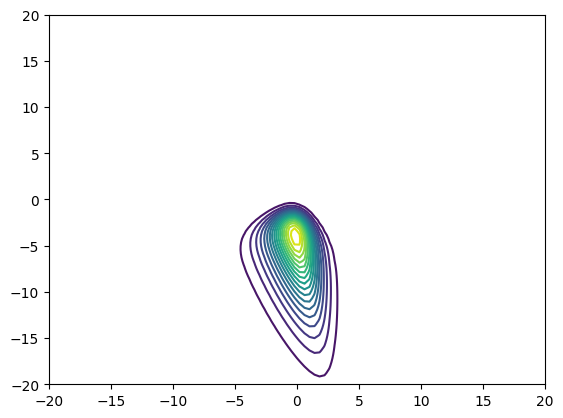

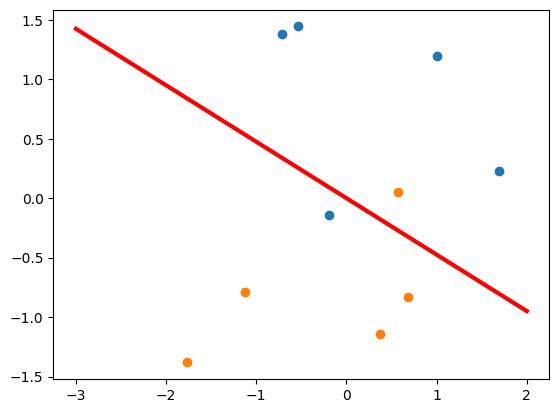

In [1]:
from src_bis.target import Target
from src_bis.optim import VI_GMM

import numpy as np 
from matplotlib  import pyplot as plt 
from einops import rearrange
import math 
from scipy.optimize import minimize


d = 2

target = Target(name = "logreg",d =  d, n_samples = 10,  meanShift=1.5, prior_eps=100 )

def objective(theta):
        return -target.model.prob(theta[None])


theta0 = np.zeros( target.model.X.shape[1])
mode = minimize(objective, theta0 ).x
print(mode)

ax = target.plot(20)
z = 2*np.linalg.inv(target.model.cov)@target.model.mean1
plt.show()

plt.scatter(target.model.X[:,0][target.model.y == 0], target.model.X[:,1][target.model.y == 0])
plt.scatter(target.model.X[:,0][target.model.y == 1], target.model.X[:,1][target.model.y == 1])
x = np.arange(-3,3)
y = -x*z[0]/z[1]
plt.plot(x, y , color = "r", lw = 3)

2


  0%|          | 2/1000 [00:00<02:36,  6.36it/s]

LR 1
KL  40.346160699001096


 50%|█████     | 502/1000 [01:19<01:11,  6.98it/s]

LR 1
KL  5.648506864491235


100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]


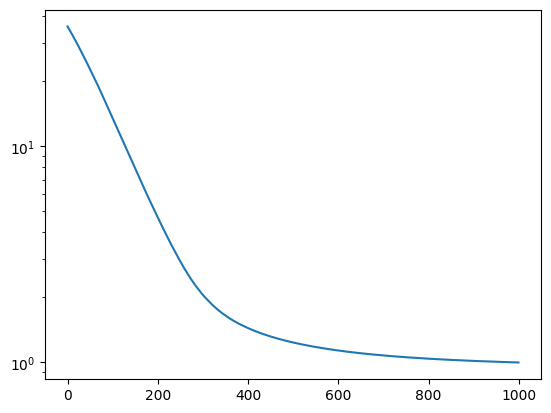

In [4]:

from src_bis.optim import VI_GMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
import numpy as np 

d = 2

target = Target("logreg", d = d, n_samples = 10,  meanShift=1.5, prior_eps=100)

vi = VI_GMM(target, mode = "iso", learning_rate = 1, n_iterations=1000, n_components = 100, scale = np.sqrt(d)*2 , BG = 100, s = np.sqrt(d) * 10, d = d)

vi.optimize(bw = True, md  = False, means_only=False, plot_iter=500, gen_noise=True,  scheduler=False, save_grads=False)


plt.semilogy(np.array(vi.kls) - np.array(vi.kls).min()+1)
# v.plot_circle(0, ax, bound=30)


<Axes: >

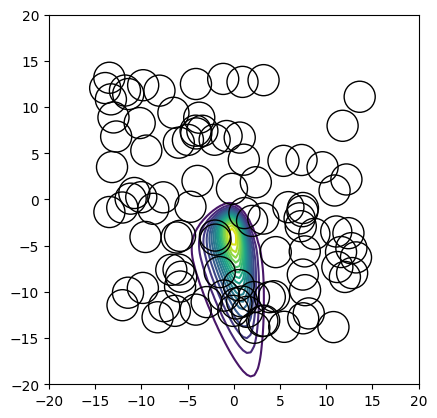

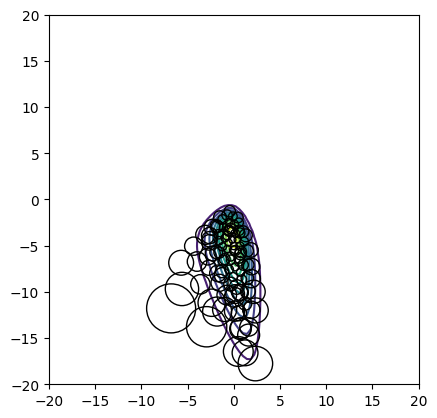

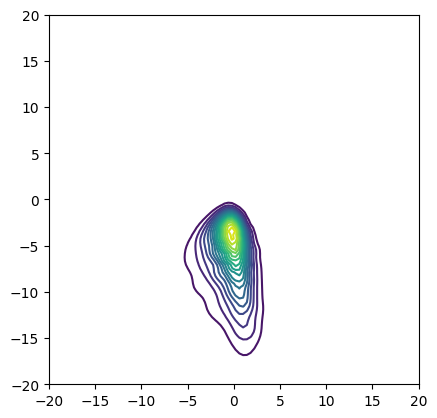

In [7]:
ax = target.plot()
vi.vgmm.plot_circle(0, ax,bound = 20)

ax = target.plot()
vi.vgmm.plot_circle(-1, ax,bound = 20)



vi.vgmm.plot_estimated()

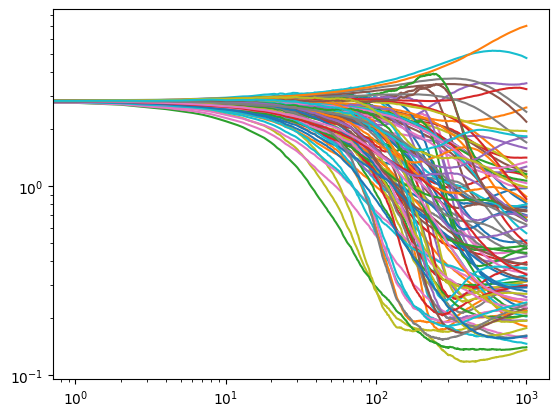

In [8]:
plt.loglog(vi.vgmm.optimized_epsilons)


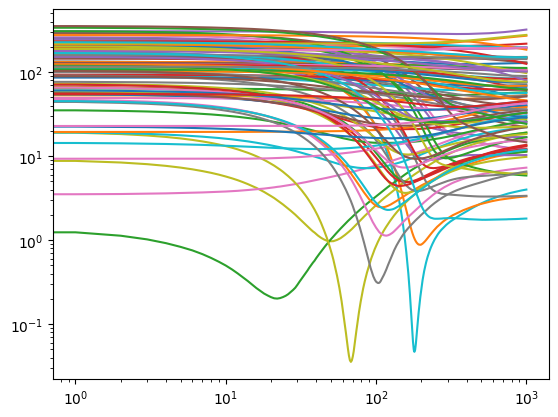

In [9]:
plt.loglog((vi.vgmm.get_means_evolution()**2).sum(axis = -1))


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


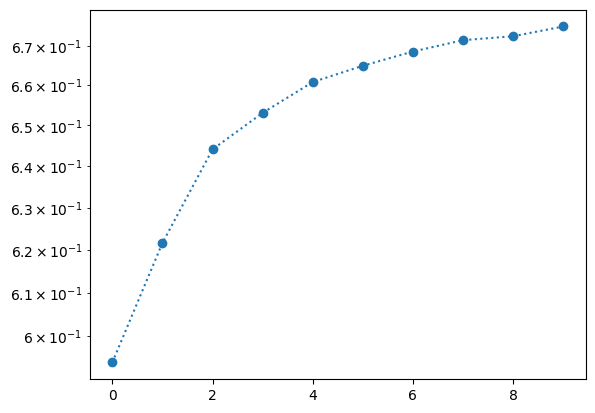

In [10]:
import tqdm 
number_of_good_y1 = []
new_x = np.random.multivariate_normal(target.model.mean1, target.model.cov, 10000)
new_x = target.model.scaler.transform(new_x)
B = 1000
noise = np.random.randn(B, d) 
component_indices = np.random.choice(vi.vgmm.n_components, size=B, p=vi.vgmm.weights)


for t  in tqdm.tqdm(range(0, vi.n_iterations, 100)):
        


    selected_means = vi.vgmm.optimized_means[t][component_indices]  # (B, d)
    selected_epsilons = vi.vgmm.optimized_epsilons[t][component_indices]  # (B, d, d)
    samples = selected_means +  (np.sqrt(selected_epsilons[:,None]) * noise)

    theta  = samples
    y = (target.model.sigmoid(np.dot(new_x,theta.T)).mean(axis = -1) > .5)*1
    number_of_good_y1.append(y.mean())
# plt.hist(y)
# print("Proba y =  1", target.model.sigmoid(np.dot(new_x,theta.T)).mean() )
plt.semilogy(number_of_good_y1, marker = "o", ls = "dotted")

100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


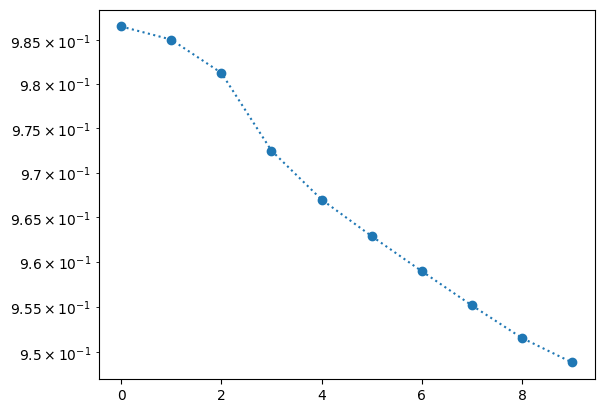

In [17]:
import tqdm 
number_of_good_y0 = []
new_x = np.random.multivariate_normal(target.model.mean0, target.model.cov, 10000)
new_x = target.model.scaler.transform(new_x)
B = 1000
noise = np.random.randn(B, d) 
component_indices = np.random.choice(vi.vgmm.n_components, size=B, p=vi.vgmm.weights)


for t  in tqdm.tqdm(range(0, vi.n_iterations, 100)):
        


    selected_means = vi.vgmm.optimized_means[t][component_indices]  # (B, d)
    selected_epsilons = vi.vgmm.optimized_epsilons[t][component_indices]  # (B, d, d)
    samples = selected_means +  (np.sqrt(selected_epsilons[:,None]) * noise)

    theta  = samples
    y = ((1 - target.model.sigmoid(np.dot(new_x,theta.T)).mean(axis = -1)) > 0.5)*1
    number_of_good_y0.append(y.mean())
# plt.hist(y)
# print("Proba y =  1", target.model.sigmoid(np.dot(new_x,theta.T)).mean() )
plt.semilogy(number_of_good_y0, marker = "o", ls = "dotted")

In [16]:
(1 - target.model.sigmoid(np.dot(new_x,theta.T)).mean(axis = -1)) > 0.5

array([ True,  True,  True, ...,  True,  True,  True])

Text(0.5, 1.0, 'rate of correct prediction for class 0 and 1 over iterations, d = 100')

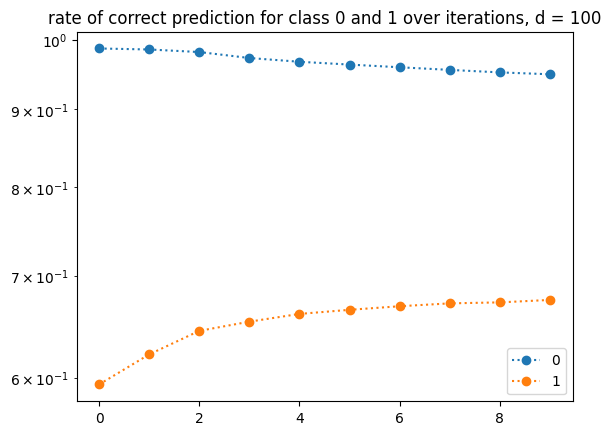

In [18]:
plt.semilogy(number_of_good_y0, marker = "o", ls = "dotted", label = "0")
plt.semilogy(number_of_good_y1, marker = "o", ls = "dotted", label = "1")
# plt.semilogy(np.array(vi.kls[1015::100])  , label = "kl")
plt.legend()
plt.title("rate of correct prediction for class 0 and 1 over iterations, d = 100")

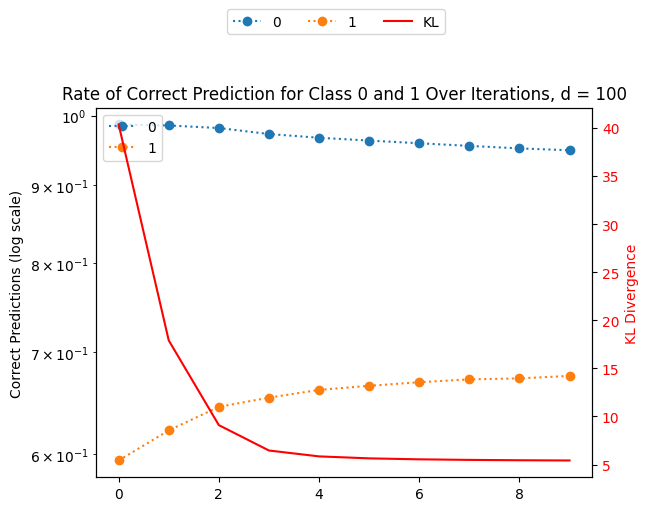

In [20]:
fig, ax1 = plt.subplots()

# Plot class 0 and 1 on the first y-axis
ax1.semilogy(number_of_good_y0, marker="o", ls="dotted", label="0")
ax1.semilogy(number_of_good_y1, marker="o", ls="dotted", label="1")
ax1.set_ylabel("Correct Predictions (log scale)")
ax1.legend(loc="upper left")
# Create a twin y-axis for KL
ax2 = ax1.twinx()
ax2.plot(np.array(vi.kls[::100]), color="red", label="KL")
ax2.set_ylabel("KL Divergence", color="red")
ax2.tick_params(axis='y', labelcolor='red')

# Title and show
plt.title("Rate of Correct Prediction for Class 0 and 1 Over Iterations, d = 100")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.show()


# Real Data


30


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/margueritetalamon/Desktop/crest/code/git/src_bis/logreg.py:93: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/Users/margueritetalamon/Desktop/crest/code/git/src_bis/logreg.py:98: RuntimeWarning: overflow encountered in exp
  lll = (self.y[:,None] * logits - np.log(1 + np.exp(logits))).sum(axis =  0)
  0%|          | 1/1000 [00:00<02:15,  7.37it/s]

LR 0.1
KL  inf


 10%|█         | 103/1000 [00:09<01:01, 14.66it/s]

LR 0.1
KL  inf


 20%|██        | 203/1000 [00:16<00:53, 14.99it/s]

LR 0.1
KL  802.9969549399137


 30%|███       | 303/1000 [00:22<00:45, 15.48it/s]

LR 0.1
KL  506.00944195058986


 40%|████      | 403/1000 [00:29<00:45, 13.20it/s]

LR 0.1
KL  332.31983828094627


 50%|█████     | 503/1000 [00:36<00:35, 13.96it/s]

LR 0.1
KL  228.52159746870805


 60%|██████    | 603/1000 [00:44<00:28, 13.79it/s]

LR 0.1
KL  165.07517021429072


 70%|███████   | 703/1000 [00:50<00:19, 15.06it/s]

LR 0.1
KL  126.61674187572764


 80%|████████  | 803/1000 [00:57<00:13, 14.88it/s]

LR 0.1
KL  103.56061536777017


 90%|█████████ | 903/1000 [01:04<00:06, 15.33it/s]

LR 0.1
KL  89.92247148916127


100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


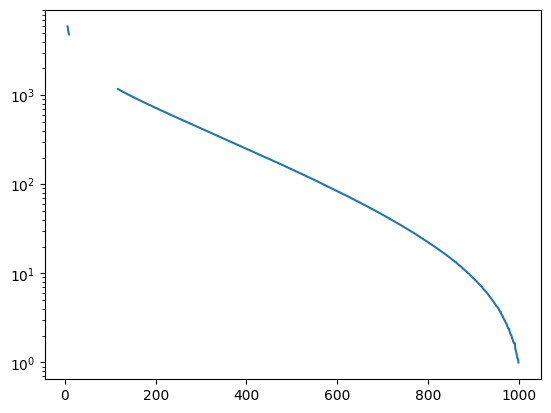

In [ ]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from matplotlib import pyplot as plt 


from src_bis.optim import VI_GMM
from src_bis.target import Target
 

data = load_breast_cancer()
train_ratio = 0.6

X = data["data"]
y =  data["target"].reshape(-1,1)
N, d = X.shape
N_train = int(train_ratio * N)
X_train = X[:N_train]
y_train = y[:N_train, 0]

X_test = X[N_train:]
y_test = y[N_train:]




target = Target("logreg", dataset = (X_train, y_train),  prior_eps = 10)

vi = VI_GMM(target, mode = "iso",learning_rate = 0.1, n_iterations=20000, n_components = 5, scale = np.sqrt(d)*10 , BG = 100, s = np.sqrt(d) * 10, d = d)

vi.optimize(bw = True, md  = False, means_only=False, plot_iter=100, gen_noise=True,  scheduler=False, save_grads=False)

plt.semilogy(np.array(vi.kls) - np.array(vi.kls).min()+1)


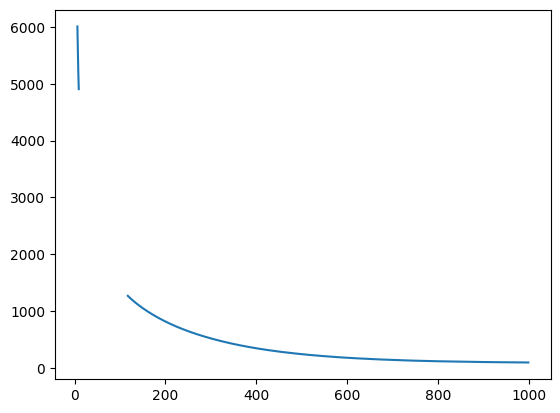

In [6]:
plt.plot(np.array(vi.kls)+10)


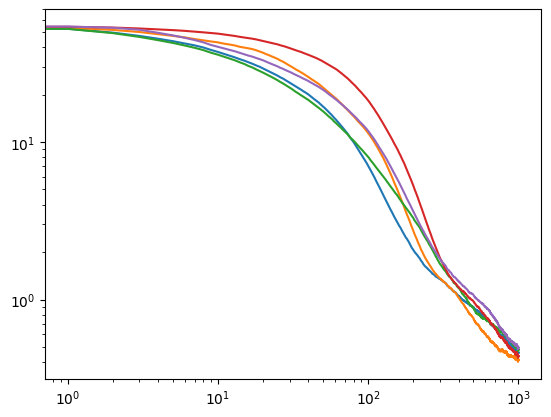

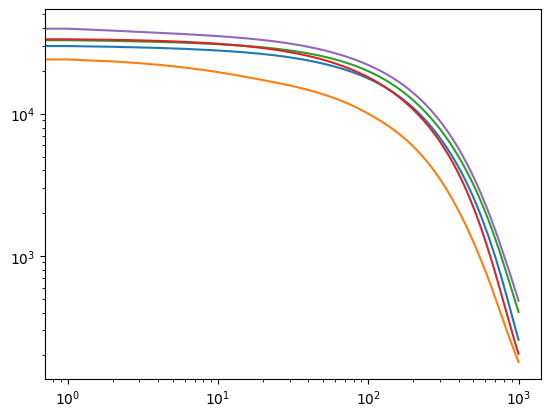

In [7]:
plt.loglog(vi.vgmm.optimized_epsilons)
plt.show()
plt.loglog((vi.vgmm.get_means_evolution()**2).sum(axis = -1))


  0%|          | 0/10 [00:00<?, ?it/s]/Users/margueritetalamon/Desktop/crest/code/git/src_bis/logreg.py:93: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
100%|██████████| 10/10 [00:00<00:00, 214.87it/s]


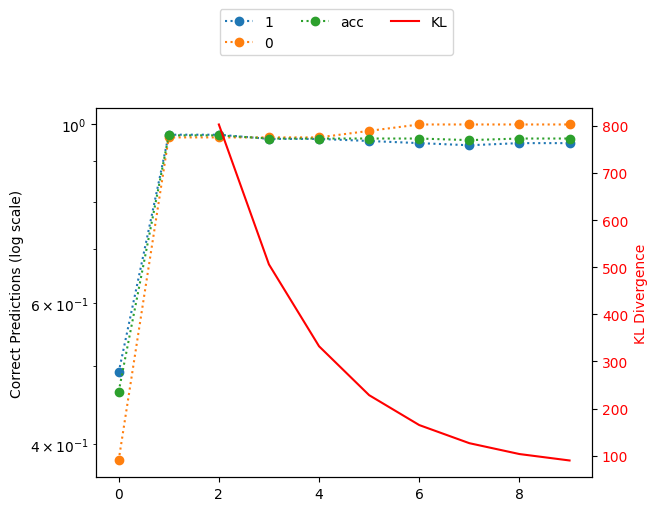

In [18]:
import tqdm 
number_of_good_y1 = []
number_of_good_y0 = []
accuracy = []
new_x = target.model.scaler.transform(X_test)
B = 1000
noise = np.random.randn(B, d) 
component_indices = np.random.choice(vi.vgmm.n_components, size=B, p=vi.vgmm.weights)

jump = 100
for t  in tqdm.tqdm(range(0, vi.n_iterations, jump)):
        


    selected_means = vi.vgmm.optimized_means[t][component_indices]  # (B, d)
    selected_epsilons = vi.vgmm.optimized_epsilons[t][component_indices]  # (B, d, d)
    samples = selected_means +  (np.sqrt(selected_epsilons[:,None]) * noise)

    theta  = samples
    y_pred = (target.model.sigmoid(np.dot(new_x,theta.T)).mean(axis = -1) > 0.5) *1
    accuracy  .append((y_pred == y_test[:,0]).mean())


    number_of_good_y1.append((y_pred[y_test[:,0] == 1] == y_test[:,0][y_test[:,0] == 1]).mean())
    number_of_good_y0.append((y_pred[y_test[:,0] == 0] == y_test[:,0][y_test[:,0] == 0]).mean())
# plt.hist(y)
# print("Proba y =  1", target.model.sigmoid(np.dot(new_x,theta.T)).mean() )
fig, ax1 = plt.subplots()

ax1.semilogy(number_of_good_y1,   label = "1", marker = "o", ls =  ":")
ax1.semilogy(number_of_good_y0,  label = "0", marker = "o", ls =  ":")
ax1.semilogy(accuracy,  label = "acc", marker = "o", ls =  ":")

ax1.set_ylabel("Correct Predictions (log scale)")
# ax1.legend(loc="upper left")

# Create a twin y-axis for KL
ax2 = ax1.twinx()
ax2.plot(np.array(vi.kls[::jump]), color="red", label="KL")
ax2.set_ylabel("KL Divergence", color="red")
ax2.tick_params(axis='y', labelcolor='red')

# Title and show
# plt.title("Rate of Correct Prediction for Class 0 and 1 Over Iterations, d = 100")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)


